# PLN Assignment 1

In the scope of the DARGMINTS project, an annotation project was carried out which consisted of annotating argumentation structures in opinion articles published in the Público newspaper. The annotation included several layers:

Selecting text spans that are taken to have an argumentative role (either as premises or conclusions of arguments) -- these are Argumentative Discourse Units (ADU).
Connecting such ADUs through support or attack relations.
Classifying the propositional content of ADUs as propositions of fact, propositions of value, or propositions of policy; within propositions of value, distinguish between those with a positive (+) or negative (-) connotation.
In a proposition of fact, the content corresponds to a piece of information that can be checked for truthness. This does not usually happen with propositions of value, which denote value judgments with a strong subjective nature; often, they also have a (positive or negative) polarity attached. A proposition of policy prescribes or suggests a certain line of action, often mentioning the agents or entities that are capable of carrying out such policies.

The aim of this assignment is to build a classifier of types of ADUs, thus focusing on the last annotation step described above. For that, you have access to two different files:

A file containing the content of each annotated ADU span and its 5-class classification: Value, Value(+), Value(-), Fact, or Policy. For each ADU, we also know the annotator and the document from which it has been taken.
A file containing details for each opinion article that has been annotated, including the full article content.
Besides ADU contents, you can make use of any contextual information provided in the corresponding opinion article.

Each opinion article has been annotated by 3 different annotators. For that reason, you will find in the ADU file an indication of which annotator has obtained the ADU. It may happen that the same ADU has been annotated by more than one annotator. When that is the case, they do not necessarily agree on the type of proposition.

How good a classifier (or set of classifiers) can you get? Don't forget to properly split the dataset in a sensible manner, so that you have a proper test set. Start by obtaining an arbitrary baseline, against which you can then compare your improvements.

## Importing the data

In order to fulfill this NLP task we will use `pandas`, `sklearn`, `nltk`, `numpy`, `matplotlib`, `seaborn` and other Python libraries


In [1]:
import pandas as pd

ADUs = pd.read_excel("data/OpArticles_ADUs.xlsx")
ADUs.isnull().values.any() #check NaNs

False

## Exploratory analysis
Firstly (since the dataset does not contains NaN's or missing values), we need to determine the class distribution for this classification problem.
Since we have a NLP classification task, it might also be relevant to do some text characterization.

In [3]:
ADUs["label"].value_counts()

Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
Name: label, dtype: int64

(array([8102.,    0., 3663.,    0.,    0., 2900.,    0., 1411.,    0.,
         667.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

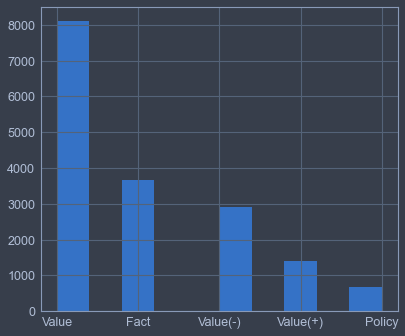

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
from jupyterthemes import jtplot

jtplot.style(theme='onedork')
plt.hist(ADUs["label"])

Some text spans were annotated by more than one annotator. Therefore, it may be the case that some text spans have different labels, which may harm the training phase.

<AxesSubplot:xlabel='annotator', ylabel='Count'>

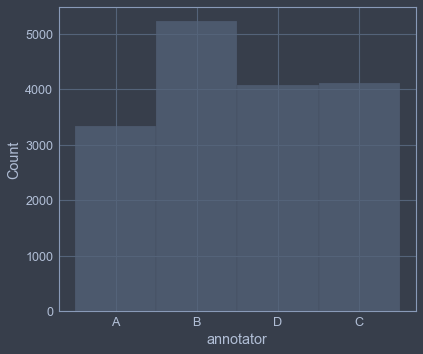

In [14]:
sb.histplot(ADUs["annotator"])

In [3]:
import numpy as np

unique_spans = np.unique(ADUs[['article_id', 'ranges']].values)
(unique_spans.shape, ADUs["tokens"].shape)

((12302,), (16743,))

As we can see, more than 4000 text spans were evaluated by more than one annotator. Now let's check how many of these text spans receive different labels

## Data preparation

The next step is to cleanup the dataset, applying text normalization techniques:
 - Removing non-alphabetic chars
 - Lowercasing
 - Removing stop words
 - Stemming/lemmatization
 
However, before applying these techniques, let's try to remove the repeated annotations that may confuse the classifiers on the future steps. In order to decide which is the correct label for each (article_id, range) pair, we compute the majority.

In [4]:
grouped_df = ADUs.groupby(by=['article_id', 'ranges'])
dataset_dict = {"tokens": [], "label": []}

for i, group in grouped_df:
    dict_counts = {x: group["label"].value_counts()[x] for x in np.unique(group[['label']].values)}
    final_label = max(dict_counts.items(), key=lambda x: x[1])
    dataset_dict["tokens"].append(group["tokens"].values[0])
    dataset_dict["label"].append(final_label[0])
    
dataset = pd.DataFrame(dataset_dict, columns = ["tokens", "label"])
dataset


,tokens,label
0,presumo que essas partilhas tenham gerado um e...,Value
1,essas partilhas tenham gerado um efeito bola d...,Value
2,o post não tardou a chegar ao conhecimento da ...,Value
3,esta questão ter [justificadamente] despertado...,Value
4,a ocasião propicia um debate amplo na sociedad...,Value
...,...,...
12016,eticamente é reprovável,Value(-)
12017,"eticamente é reprovável e, o bom senso, aconse...",Value
12018,"o bom senso, aconselha a não o fazer",Value
12019,Um presidente de câmara pode ter a sua preferê...,Value


In [7]:
print(ADUs["label"].value_counts())
dataset["label"].value_counts()

Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
Name: label, dtype: int64


Value       5748
Fact        3001
Value(-)    1872
Value(+)     889
Policy       511
Name: label, dtype: int64

We managed to reduce the amount of rows in the dataframe -> some of them had repeated/conflictuous labels. 

In [ ]:
import nltk
#nltk.download('rslp')
"""
following steps install different Jupyter Notebook themes -> dark mode
 >> conda install jupyterthemes
 >> jt -f firacode -t onedork


"""

In [5]:
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer # portuguese stemmer
corpus = []
stemmer = RSLPStemmer()
for i in range(0, dataset['tokens'].size):
    # get review and remove non alpha chars
    review = re.sub('[^a-zA-Z]', ' ', dataset['tokens'][i])
    # to lower-case
    review = review.lower()
    # split into tokens, apply stemming and remove stop words
    review = ' '.join([stemmer.stem(w) for w in review.split() if not w in set(stopwords.words('portuguese'))])
    corpus.append(review)

print(corpus)

['presum partilh ger efeit bol nev', 'partilh ger efeit bol nev', 'post n tard cheg conhec imprens pr pri port edit', 'quest ter justificad despert aten p blic', 'ocas propic debat ampl sociedad civil', 'ocas propic debat ampl sociedad civil sobretud tom urgent med part tutel sent cobr uso sistem ensin ve cul propag ideolog coloni racist', 'tom urgent med part tutel sent cobr uso sistem ensin ve cul propag ideolog coloni racist', 'acord autor dest livr edit apen portugues merec ser represent agent hist ria', 'tod rest pov encontr', 'j si probl tic term pedag gic', 'probl tic term pedag gic', 'assim ide faz carn', 'tamb m conden vel term cient fic tic', 'confront font hist ric n permit deduz car ct amig vel pac fic encontr refer', 'ensin ment hist ric n compat vel aprendiz viv nci democr tic', 'autor livr naturaliz escraviz afric', 'coloc term escrav colun correspond produt traz portug aceit vel pesso trat mercad', 'coloc term escrav colun correspond produt traz portug', 'propost pedag 

## Generating a data set

We need to transform the corpus into a collection that can be handled by a machine learning model. We will be using `sklearn`'s TfidfVectorizer class

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

#set max_features = 10000 to select k features with the highest corpus frequency
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df = 2)
X = vectorizer.fit_transform(corpus).toarray()

print(X.shape)
X

(12021, 22637)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
print(vectorizer.get_feature_names())

['aachen', 'aachen aix', 'abaix', 'abaix assin', 'abaix dia', 'abaix doi', 'abaix previst', 'abaix princip', 'abaix result', 'aban', 'abandon', 'abandon complet', 'abandon empreg', 'abandon rea', 'abarc', 'abarc multidimensional', 'abarc tod', 'abarrot', 'abastec', 'abastec cade', 'abastec gua', 'abat', 'abat imprim', 'abat mamarrach', 'abat pod', 'abat sobr', 'abdic', 'abdic ide', 'abdic ir', 'abdic tamb', 'aberr', 'aberr filosof', 'abert', 'abert coloc', 'abert concurs', 'abert corr', 'abert escravat', 'abert melhor', 'abert mund', 'abert permit', 'abert popul', 'abert urn', 'abol', 'abord', 'abord conjunt', 'abord dram', 'abord nov', 'abord quest', 'abord trat', 'abort', 'abort ortogr', 'abr', 'abr caminh', 'abr concurs', 'abr debat', 'abr enorm', 'abr final', 'abr melhor', 'abr nenhum', 'abr nov', 'abr port', 'abr talh', 'abrand', 'abrand cresc', 'abrand econom', 'abrang', 'abrang nci', 'abrang regim', 'abrang tod', 'abrig', 'abril', 'abrupt', 'absolut', 'absolut comport', 'absolut

C:\Users\caion\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
y = dataset["label"]
print(y.shape)
print(y.head())

(12021,)
0    Value
1    Value
2    Value
3    Value
4    Value
Name: label, dtype: object


## Splitting the dataset into training and testing

The next step is to split the dataset into training and testing. We will be using a 80%-20% split. Since classes are unbalanced (*Value* examples are significantly more abundant than *Policy* examples), we need to stratify both sets -> try to get a similar class distribution for each set.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(9616, 22637) (9616,)
(2405, 22637) (2405,)

Label distribution in the training set:
Value       4599
Fact        2398
Value(-)    1489
Value(+)     708
Policy       422
Name: label, dtype: int64

Label distribution in the test set:
Value       1149
Fact         603
Value(-)     383
Value(+)     181
Policy        89
Name: label, dtype: int64


## Feature Selection

In order to escape the **Curse of dimmensionality**, we need to apply feature selection. 

In [21]:
from sklearn.feature_selection import SelectKBest, chi2

n_features = 5000

#X_new = SelectKBest(chi2, k=n_features).fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train.shape

(9616, 8667)

## Training the models
We are finally ready to start training some models. To start off, we will train a single (`Naive Bayes`) classifier that evaluates the likelihood of a document being of one of the 5 classes. This will set the baseline for which the improvements will be measured.

In [17]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy score:  0.49480249480249483


C:\Users\caion\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


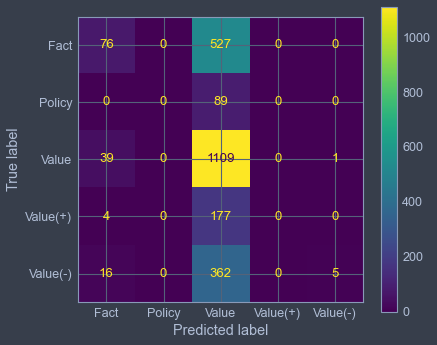

,Precision,Recall,F1
Fact,0.562963,0.126036,0.205962
Policy,0.000000,0.000000,0.000000
Value,0.489841,0.965187,0.649868
Value(+),0.000000,0.000000,0.000000
Value(-),0.833333,0.013055,0.025707


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_metrics(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    print("Accuracy score: ", accuracy_score(y_test, y_pred))
    metrics_df = pd.DataFrame({"Precision": precision_score(y_test, y_pred, labels = classes, average = None).tolist(),
                              "Recall": recall_score(y_test, y_pred, labels = classes, average = None).tolist(),
                              "F1": f1_score(y_test, y_pred, labels = classes, average = None).tolist()},
                             index = classes)
    
    plt.show()
    return metrics_df.head()
    
print_metrics(y_test, y_pred, clf.classes_)

Since some classifiers like SVM and Logistic Regression cannot handle multi-class classification, let's use the One vs Rest classifier. This way, we can transform this problem into a binary classification problem -> one classifier for each class.

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

model_to_set = RandomForestClassifier(n_jobs=-1, max_samples=0.25,
                                     max_depth=50)

parameters = {
    "max_depth": [int(x) for x in np.linspace(10, 110, num=5)],
    "min_samples_leaf": [int(x) for x in np.linspace(50, 2000, num=5)],
    "criterion": ["gini", "entropy"]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters,
                             scoring="roc_auc_ovr", cv=5, n_jobs=-1, verbose=1)

model_tunning.fit(X_train, y_train)
model_tunning.best_score_



Fitting 5 folds for each of 50 candidates, totalling 250 fits


MemoryError: Unable to allocate 332. MiB for an array with shape (1924, 22637) and data type float64

## Scaling the data

Some linear models (like SVM or SGD classifiers) use euclidean distances and benefit from the normalization of the data.

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## SGD Classifier

Let's now apply the Stochastic Gradient Descent optimization with a linear SVM model (`loss='hinge'`) and a Logistic Regression model (`loss=log`). Moreover, we can tune some hyperparameters to get the best possible model.
SGD implementation from sklearn optimizes the loss function to converge faster, as they use stochastic gradient descent instead of gradient descent.

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\caion\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


{'alpha': 0.001, 'loss': 'log'}
Accuracy score:  0.49272349272349275


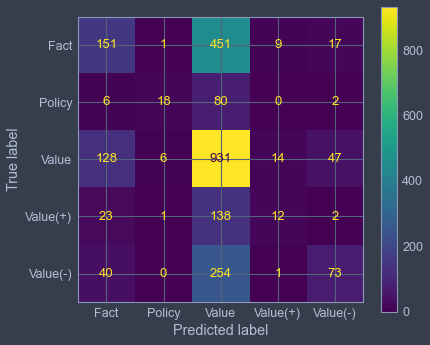

,Precision,Recall,F1
Fact,0.433908,0.240064,0.309110
Policy,0.692308,0.169811,0.272727
Value,0.502157,0.826821,0.624832
Value(+),0.333333,0.068182,0.113208
Value(-),0.517730,0.198370,0.286837


In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

"""
l1-regularization -> 'built-in' feature selection (fewer features)
l2-regularization -> Prefers weight vectors with many small weights
"""

max_iterations = 10**6/np.ceil(X_train.shape[0] / 10) #Empirically,the model converges after 10^6/n where n 
                                        # the size of the test set

sgd_model = SGDClassifier(penalty="l2", 
                          max_iter=np.ceil(max_iterations/10), average=True)
sgd_gs = GridSearchCV(sgd_model, n_jobs=-1, param_grid={
    "alpha": 10.0**-np.arange(1,5),
    "loss": ['log', 'modified_huber']
}, cv=5, scoring="f1_weighted", verbose = 1)

sgd_gs.fit(X_train, y_train)
#sgd_gs.best_score_
print(sgd_gs.best_params_)
print_metrics(y_test, sgd_gs.predict(X_test), sgd_gs.classes_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


-- Epoch 1
-- Epoch 1
-- Epoch 1-- Epoch 1

-- Epoch 1
Norm: 3054.77, NNZs: 8634, Bias: -7321.558252, T: 9616, Avg. loss: 1110.933500
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 3913.81, NNZs: 8634, Bias: -3917.234766, T: 9616, Avg. loss: 1797.711803
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 3203.01, NNZs: 8634, Bias: -6730.494603, T: 9616, Avg. loss: 1301.881271
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 3647.60, NNZs: 8634, Bias: -5401.571781, T: 9616, Avg. loss: 1512.212080
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 4049.03, NNZs: 8634, Bias: -938.453505, T: 9616, Avg. loss: 1968.460776
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 1940.57, NNZs: 8634, Bias: -7149.436379, T: 19232, Avg. loss: 115.442539
Total training time: 0.24 seconds.
-- Epoch 3
Norm: 2203.90, NNZs: 8634, Bias: -6410.701912, T: 19232, Avg. loss: 224.633005
Total training time: 0.25 seconds.
-- Epoch 3
Norm: 2662.27, NNZs: 8634, Bias: -3237.073872, T: 19232, Avg. loss: 493

-- Epoch 16
Norm: 614.14, NNZs: 8634, Bias: -105.586938, T: 134624, Avg. loss: 27.184931
Total training time: 1.84 seconds.
-- Epoch 15
Norm: 1572.60, NNZs: 8634, Bias: -3353.831741, T: 144240, Avg. loss: 36.107249
Total training time: 1.85 seconds.
-- Epoch 16
Norm: 1220.50, NNZs: 8634, Bias: -1607.142999, T: 144240, Avg. loss: 27.257304
Total training time: 1.89 seconds.
-- Epoch 16
Norm: 1262.85, NNZs: 8634, Bias: -6607.361908, T: 153856, Avg. loss: 27.497507
Total training time: 1.90 seconds.
-- Epoch 17
Norm: 1523.75, NNZs: 8634, Bias: -5433.833609, T: 153856, Avg. loss: 45.851314
Total training time: 1.93 seconds.
-- Epoch 17
Norm: 584.82, NNZs: 8634, Bias: -99.534253, T: 144240, Avg. loss: 25.911997
Total training time: 1.96 seconds.
-- Epoch 16
Norm: 1550.10, NNZs: 8634, Bias: -3314.644586, T: 153856, Avg. loss: 33.446321
Total training time: 1.96 seconds.
-- Epoch 17
Norm: 1191.05, NNZs: 8634, Bias: -1570.972594, T: 153856, Avg. loss: 25.344319
Total training time: 2.01 second

Norm: 1383.01, NNZs: 8634, Bias: -2937.729097, T: 288480, Avg. loss: 20.674288
Total training time: 3.66 seconds.
-- Epoch 31
Norm: 1223.66, NNZs: 8634, Bias: -6439.697336, T: 298096, Avg. loss: 22.980090
Total training time: 3.67 seconds.
-- Epoch 32
Norm: 357.53, NNZs: 8634, Bias: -65.547343, T: 278864, Avg. loss: 10.936118
Total training time: 3.70 seconds.
-- Epoch 30
Norm: 946.90, NNZs: 8634, Bias: -1254.388356, T: 288480, Avg. loss: 11.557405
Total training time: 3.72 seconds.
-- Epoch 31
Norm: 1450.72, NNZs: 8634, Bias: -5141.896458, T: 298096, Avg. loss: 35.022468
Total training time: 3.71 seconds.
-- Epoch 32
Norm: 1222.35, NNZs: 8634, Bias: -6431.647601, T: 307712, Avg. loss: 22.720354
Total training time: 3.79 seconds.
-- Epoch 33
Norm: 1375.69, NNZs: 8634, Bias: -2918.722429, T: 298096, Avg. loss: 20.004881
Total training time: 3.78 seconds.
-- Epoch 32
Norm: 348.44, NNZs: 8634, Bias: -63.878895, T: 288480, Avg. loss: 10.831950
Total training time: 3.82 seconds.
-- Epoch 31

-- Epoch 46
Norm: 822.97, NNZs: 8634, Bias: -1093.533736, T: 423104, Avg. loss: 7.139489
Total training time: 5.35 seconds.
-- Epoch 45
Norm: 266.50, NNZs: 8634, Bias: -50.117253, T: 413488, Avg. loss: 6.739590
Total training time: 5.37 seconds.
-- Epoch 44
Norm: 1206.32, NNZs: 8634, Bias: -6340.578046, T: 442336, Avg. loss: 20.846575
Total training time: 5.38 seconds.
-- Epoch 47
Norm: 1284.48, NNZs: 8634, Bias: -2715.354683, T: 432720, Avg. loss: 15.323059
Total training time: 5.41 seconds.
-- Epoch 46
Norm: 1411.45, NNZs: 8634, Bias: -4972.701222, T: 442336, Avg. loss: 30.884349
Total training time: 5.44 seconds.
-- Epoch 47
Norm: 816.17, NNZs: 8634, Bias: -1084.774710, T: 432720, Avg. loss: 7.166578
Total training time: 5.47 seconds.
-- Epoch 46
Norm: 261.94, NNZs: 8634, Bias: -49.590068, T: 423104, Avg. loss: 6.275714
Total training time: 5.48 seconds.
-- Epoch 45
Norm: 1204.95, NNZs: 8634, Bias: -6335.294683, T: 451952, Avg. loss: 20.851720
Total training time: 5.49 seconds.
-- E

-- Epoch 58
Norm: 1222.08, NNZs: 8634, Bias: -2575.432528, T: 567344, Avg. loss: 12.891574
Total training time: 7.00 seconds.
-- Epoch 60
Norm: 1384.76, NNZs: 8634, Bias: -4861.305290, T: 576960, Avg. loss: 27.794250
Total training time: 7.02 seconds.
-- Epoch 61
Norm: 1194.81, NNZs: 8634, Bias: -6270.288076, T: 586576, Avg. loss: 19.864949
Total training time: 7.03 seconds.
-- Epoch 62
Norm: 738.42, NNZs: 8634, Bias: -984.519278, T: 567344, Avg. loss: 4.933479
Total training time: 7.05 seconds.
-- Epoch 60
Norm: 213.79, NNZs: 8634, Bias: -40.450580, T: 557728, Avg. loss: 4.956744
Total training time: 7.09 seconds.
-- Epoch 59
Norm: 1218.60, NNZs: 8634, Bias: -2566.821841, T: 576960, Avg. loss: 12.642292
Total training time: 7.11 seconds.
-- Epoch 61
Norm: 1382.52, NNZs: 8634, Bias: -4854.598915, T: 586576, Avg. loss: 28.014371
Total training time: 7.13 seconds.
-- Epoch 62
Norm: 1194.06, NNZs: 8634, Bias: -6266.272953, T: 596192, Avg. loss: 19.754431
Total training time: 7.14 seconds.

-- Epoch 74
Norm: 1364.69, NNZs: 8634, Bias: -4774.443859, T: 711584, Avg. loss: 26.183536
Total training time: 8.61 seconds.
-- Epoch 75
Norm: 683.91, NNZs: 8634, Bias: -911.189327, T: 701968, Avg. loss: 4.111077
Total training time: 8.66 seconds.
-- Epoch 74
Norm: 1185.79, NNZs: 8634, Bias: -6215.953894, T: 730816, Avg. loss: 19.074462
Total training time: 8.71 seconds.
-- Epoch 77
Norm: 182.46, NNZs: 8634, Bias: -34.016318, T: 692352, Avg. loss: 3.740622
Total training time: 8.71 seconds.
-- Epoch 73
Norm: 1172.51, NNZs: 8634, Bias: -2463.171622, T: 711584, Avg. loss: 10.947935
Total training time: 8.72 seconds.
-- Epoch 75
Norm: 1363.45, NNZs: 8634, Bias: -4768.913926, T: 721200, Avg. loss: 26.062146
Total training time: 8.73 seconds.
-- Epoch 76
Norm: 680.78, NNZs: 8634, Bias: -906.530344, T: 711584, Avg. loss: 4.090648
Total training time: 8.77 seconds.
-- Epoch 75
Norm: 1184.67, NNZs: 8634, Bias: -6212.846071, T: 740432, Avg. loss: 18.975101
Total training time: 8.82 seconds.
--

-- Epoch 91
Norm: 1347.17, NNZs: 8634, Bias: -4698.966919, T: 855824, Avg. loss: 24.836376
Total training time: 10.27 seconds.
-- Epoch 90
Norm: 1135.60, NNZs: 8634, Bias: -2380.387500, T: 846208, Avg. loss: 9.864183
Total training time: 10.27 seconds.
-- Epoch 89
Norm: 1179.01, NNZs: 8634, Bias: -6171.579276, T: 875056, Avg. loss: 18.488641
Total training time: 10.31 seconds.
-- Epoch 92
Norm: 1346.09, NNZs: 8634, Bias: -4694.430408, T: 865440, Avg. loss: 24.693912
Total training time: 10.36 seconds.
-- Epoch 91
Norm: 1132.74, NNZs: 8634, Bias: -2375.309828, T: 855824, Avg. loss: 9.761493
Total training time: 10.37 seconds.
-- Epoch 90
Norm: 1178.39, NNZs: 8634, Bias: -6168.935260, T: 884672, Avg. loss: 18.417875
Total training time: 10.40 seconds.
-- Epoch 93
Norm: 1344.93, NNZs: 8634, Bias: -4689.979317, T: 875056, Avg. loss: 24.658967
Total training time: 10.46 seconds.
-- Epoch 92
Norm: 1130.34, NNZs: 8634, Bias: -2370.100867, T: 865440, Avg. loss: 9.700054
Total training time: 10

-- Epoch 113
Norm: 1170.55, NNZs: 8634, Bias: -6116.391844, T: 1096224, Avg. loss: 17.790143
Total training time: 12.50 seconds.
-- Epoch 115
Norm: 1087.81, NNZs: 8634, Bias: -2273.346528, T: 1067376, Avg. loss: 8.426229
Total training time: 12.51 seconds.
-- Epoch 112
Norm: 1324.72, NNZs: 8634, Bias: -4602.640619, T: 1086608, Avg. loss: 23.203817
Total training time: 12.59 seconds.
-- Epoch 114
Norm: 1170.08, NNZs: 8634, Bias: -6114.287405, T: 1105840, Avg. loss: 17.804128
Total training time: 12.59 seconds.
-- Epoch 116
Norm: 1085.99, NNZs: 8634, Bias: -2269.303788, T: 1076992, Avg. loss: 8.467564
Total training time: 12.61 seconds.
-- Epoch 113
Norm: 1323.65, NNZs: 8634, Bias: -4599.181570, T: 1096224, Avg. loss: 23.104702
Total training time: 12.69 seconds.
-- Epoch 115
Norm: 1169.52, NNZs: 8634, Bias: -6112.218768, T: 1115456, Avg. loss: 17.747503
Total training time: 12.69 seconds.
-- Epoch 117
Norm: 1084.30, NNZs: 8634, Bias: -2265.251410, T: 1086608, Avg. loss: 8.392351
Total t

-- Epoch 138
Norm: 1308.37, NNZs: 8634, Bias: -4531.751395, T: 1298160, Avg. loss: 22.036710
Total training time: 14.66 seconds.
-- Epoch 136
Norm: 1051.14, NNZs: 8634, Bias: -2189.362520, T: 1288544, Avg. loss: 7.591267
Total training time: 14.70 seconds.
-- Epoch 135
Norm: 1163.58, NNZs: 8634, Bias: -6069.833546, T: 1327008, Avg. loss: 17.306660
Total training time: 14.73 seconds.
-- Epoch 139
Norm: 1307.44, NNZs: 8634, Bias: -4528.899843, T: 1307776, Avg. loss: 21.995257
Total training time: 14.75 seconds.
-- Epoch 137
Norm: 1049.26, NNZs: 8634, Bias: -2186.319548, T: 1298160, Avg. loss: 7.510773
Total training time: 14.79 seconds.
-- Epoch 136
Norm: 1162.97, NNZs: 8634, Bias: -6068.145636, T: 1336624, Avg. loss: 17.220911
Total training time: 14.82 seconds.
-- Epoch 140
Norm: 1306.71, NNZs: 8634, Bias: -4526.015662, T: 1317392, Avg. loss: 21.941644
Total training time: 14.84 seconds.
-- Epoch 138
Norm: 1047.80, NNZs: 8634, Bias: -2183.114746, T: 1307776, Avg. loss: 7.462018
Total t

Norm: 1157.85, NNZs: 8634, Bias: -6032.472465, T: 1548176, Avg. loss: 16.889578
Total training time: 16.87 seconds.
-- Epoch 162
Norm: 1020.49, NNZs: 8634, Bias: -2121.186754, T: 1509712, Avg. loss: 6.831910
Total training time: 16.90 seconds.
-- Epoch 158
Norm: 1293.28, NNZs: 8634, Bias: -4467.305302, T: 1528944, Avg. loss: 21.124863
Total training time: 16.93 seconds.
-- Epoch 160
Norm: 1157.80, NNZs: 8634, Bias: -6030.941115, T: 1557792, Avg. loss: 16.868878
Total training time: 16.96 seconds.
-- Epoch 163
Norm: 1019.43, NNZs: 8634, Bias: -2118.423061, T: 1519328, Avg. loss: 6.804950
Total training time: 16.99 seconds.
-- Epoch 159
Norm: 1292.66, NNZs: 8634, Bias: -4464.862097, T: 1538560, Avg. loss: 20.950261
Total training time: 17.03 seconds.
-- Epoch 161
Norm: 1157.41, NNZs: 8634, Bias: -6029.483438, T: 1567408, Avg. loss: 16.858355
Total training time: 17.06 seconds.
-- Epoch 164
Norm: 1018.07, NNZs: 8634, Bias: -2115.827345, T: 1528944, Avg. loss: 6.797546
Total training time:

-- Epoch 179
Norm: 1153.59, NNZs: 8634, Bias: -6001.458879, T: 1759728, Avg. loss: 16.573978
Total training time: 18.92 seconds.
-- Epoch 184
Norm: 1281.78, NNZs: 8634, Bias: -4418.936555, T: 1730880, Avg. loss: 20.320768
Total training time: 18.93 seconds.
-- Epoch 181
Norm: 995.84, NNZs: 8634, Bias: -2066.143330, T: 1721264, Avg. loss: 6.310339
Total training time: 18.99 seconds.
-- Epoch 180
Norm: 1153.27, NNZs: 8634, Bias: -6000.167561, T: 1769344, Avg. loss: 16.515282
Total training time: 19.02 seconds.
-- Epoch 185
Norm: 1281.41, NNZs: 8634, Bias: -4416.743141, T: 1740496, Avg. loss: 20.312871
Total training time: 19.02 seconds.
-- Epoch 182
Norm: 995.01, NNZs: 8634, Bias: -2063.735443, T: 1730880, Avg. loss: 6.265591
Total training time: 19.09 seconds.
-- Epoch 181
Norm: 1152.86, NNZs: 8634, Bias: -5998.900166, T: 1778960, Avg. loss: 16.527271
Total training time: 19.11 seconds.
-- Epoch 186
Norm: 1280.77, NNZs: 8634, Bias: -4414.642061, T: 1750112, Avg. loss: 20.191154
Total tr

-- Epoch 206
Norm: 975.67, NNZs: 8634, Bias: -2020.464500, T: 1923200, Avg. loss: 5.896837
Total training time: 20.97 seconds.
-- Epoch 201
Norm: 1271.26, NNZs: 8634, Bias: -4374.296309, T: 1942432, Avg. loss: 19.627114
Total training time: 20.98 seconds.
-- Epoch 203
Norm: 1149.13, NNZs: 8634, Bias: -5972.986990, T: 1980896, Avg. loss: 16.258911
Total training time: 21.03 seconds.
-- Epoch 207
Norm: 974.74, NNZs: 8634, Bias: -2018.448607, T: 1932816, Avg. loss: 5.843579
Total training time: 21.06 seconds.
-- Epoch 202
Norm: 1271.17, NNZs: 8634, Bias: -4372.289857, T: 1952048, Avg. loss: 19.684807
Total training time: 21.07 seconds.
-- Epoch 204
Norm: 1149.24, NNZs: 8634, Bias: -5971.769111, T: 1990512, Avg. loss: 16.275866
Total training time: 21.12 seconds.
-- Epoch 208
Norm: 973.95, NNZs: 8634, Bias: -2016.375602, T: 1942432, Avg. loss: 5.909066
Total training time: 21.16 seconds.
-- Epoch 203
Norm: 1270.66, NNZs: 8634, Bias: -4370.410857, T: 1961664, Avg. loss: 19.652399
Total trai

-- Epoch 222
Norm: 1145.81, NNZs: 8634, Bias: -5949.649668, T: 2182832, Avg. loss: 16.036636
Total training time: 22.98 seconds.
-- Epoch 228
Norm: 1262.08, NNZs: 8634, Bias: -4334.501315, T: 2153984, Avg. loss: 19.172462
Total training time: 23.05 seconds.
-- Epoch 225
Norm: 956.79, NNZs: 8634, Bias: -1978.437464, T: 2134752, Avg. loss: 5.516501
Total training time: 23.06 seconds.
-- Epoch 223
Norm: 1145.47, NNZs: 8634, Bias: -5948.630931, T: 2192448, Avg. loss: 16.032121
Total training time: 23.08 seconds.
-- Epoch 229
Norm: 1261.60, NNZs: 8634, Bias: -4332.816110, T: 2163600, Avg. loss: 19.153207
Total training time: 23.14 seconds.
-- Epoch 226
Norm: 955.91, NNZs: 8634, Bias: -1976.681293, T: 2144368, Avg. loss: 5.505801
Total training time: 23.15 seconds.
-- Epoch 224
Norm: 1145.40, NNZs: 8634, Bias: -5947.566700, T: 2202064, Avg. loss: 16.035637
Total training time: 23.17 seconds.
-- Epoch 230
Norm: 1261.29, NNZs: 8634, Bias: -4331.092589, T: 2173216, Avg. loss: 19.126580
Total tr

-- Epoch 243
Norm: 1142.56, NNZs: 8634, Bias: -5927.486387, T: 2394384, Avg. loss: 15.823311
Total training time: 25.02 seconds.
-- Epoch 250
Norm: 1254.09, NNZs: 8634, Bias: -4300.241438, T: 2355920, Avg. loss: 18.661392
Total training time: 25.02 seconds.
-- Epoch 246
Norm: 941.10, NNZs: 8634, Bias: -1942.485887, T: 2336688, Avg. loss: 5.265676
Total training time: 25.04 seconds.
-- Epoch 244
Norm: 1142.24, NNZs: 8634, Bias: -5926.561590, T: 2404000, Avg. loss: 15.819906
Total training time: 25.11 seconds.
-- Epoch 251
Norm: 1253.69, NNZs: 8634, Bias: -4298.700492, T: 2365536, Avg. loss: 18.692184
Total training time: 25.12 seconds.
-- Epoch 247
Norm: 940.17, NNZs: 8634, Bias: -1940.970743, T: 2346304, Avg. loss: 5.174783
Total training time: 25.13 seconds.
-- Epoch 245
Norm: 1142.01, NNZs: 8634, Bias: -5925.623794, T: 2413616, Avg. loss: 15.818808
Total training time: 25.21 seconds.
-- Epoch 252
Norm: 1253.32, NNZs: 8634, Bias: -4297.157294, T: 2375152, Avg. loss: 18.619754
Total tr

Norm: 1246.64, NNZs: 8634, Bias: -4269.022845, T: 2557856, Avg. loss: 18.322063
Total training time: 26.99 seconds.
-- Epoch 267
Norm: 926.50, NNZs: 8634, Bias: -1910.236294, T: 2538624, Avg. loss: 4.967424
Total training time: 27.02 seconds.
-- Epoch 265
Norm: 1139.16, NNZs: 8634, Bias: -5907.331053, T: 2605936, Avg. loss: 15.615808
Total training time: 27.06 seconds.
-- Epoch 272
Norm: 1246.11, NNZs: 8634, Bias: -4267.657970, T: 2567472, Avg. loss: 18.309026
Total training time: 27.08 seconds.
-- Epoch 268
Norm: 926.03, NNZs: 8634, Bias: -1908.684301, T: 2548240, Avg. loss: 4.975683
Total training time: 27.12 seconds.
-- Epoch 266
Norm: 1139.48, NNZs: 8634, Bias: -5906.366317, T: 2615552, Avg. loss: 15.660817
Total training time: 27.15 seconds.
-- Epoch 273
Norm: 1245.72, NNZs: 8634, Bias: -4266.259004, T: 2577088, Avg. loss: 18.237908
Total training time: 27.18 seconds.
-- Epoch 269
Norm: 925.24, NNZs: 8634, Bias: -1907.294656, T: 2557856, Avg. loss: 4.949027
Total training time: 27

-- Epoch 289
Norm: 1136.78, NNZs: 8634, Bias: -5888.650194, T: 2817488, Avg. loss: 15.447604
Total training time: 29.08 seconds.
-- Epoch 294
Norm: 912.81, NNZs: 8634, Bias: -1879.446323, T: 2750176, Avg. loss: 4.702045
Total training time: 29.09 seconds.
-- Epoch 287
Norm: 1239.23, NNZs: 8634, Bias: -4237.690942, T: 2779024, Avg. loss: 17.876806
Total training time: 29.14 seconds.
-- Epoch 290
Norm: 1136.64, NNZs: 8634, Bias: -5887.842727, T: 2827104, Avg. loss: 15.455472
Total training time: 29.17 seconds.
-- Epoch 295
Norm: 912.17, NNZs: 8634, Bias: -1878.136735, T: 2759792, Avg. loss: 4.733674
Total training time: 29.18 seconds.
-- Epoch 288
Norm: 1238.81, NNZs: 8634, Bias: -4236.423645, T: 2788640, Avg. loss: 17.856287
Total training time: 29.24 seconds.
-- Epoch 291
Norm: 1136.55, NNZs: 8634, Bias: -5887.027386, T: 2836720, Avg. loss: 15.449137
Total training time: 29.27 seconds.
-- Epoch 296
Norm: 911.53, NNZs: 8634, Bias: -1876.831577, T: 2769408, Avg. loss: 4.715864
Total trai

Norm: 1133.22, NNZs: 8634, Bias: -5864.732656, T: 3115584, Avg. loss: 15.244752
Total training time: 31.84 seconds.
-- Epoch 325
Norm: 1230.25, NNZs: 8634, Bias: -4200.662594, T: 3067504, Avg. loss: 17.433475
Total training time: 31.86 seconds.
-- Epoch 320
Norm: 1133.22, NNZs: 8634, Bias: -5863.979899, T: 3125200, Avg. loss: 15.243129
Total training time: 31.93 seconds.
-- Epoch 326
Norm: 1230.01, NNZs: 8634, Bias: -4199.478461, T: 3077120, Avg. loss: 17.436528
Total training time: 31.95 seconds.
-- Epoch 321
Norm: 1133.10, NNZs: 8634, Bias: -5863.251798, T: 3134816, Avg. loss: 15.220242
Total training time: 32.02 seconds.
-- Epoch 327
Norm: 1229.77, NNZs: 8634, Bias: -4198.301179, T: 3086736, Avg. loss: 17.381927
Total training time: 32.04 seconds.
-- Epoch 322
Norm: 1132.91, NNZs: 8634, Bias: -5862.541784, T: 3144432, Avg. loss: 15.206518
Total training time: 32.11 seconds.
-- Epoch 328
Norm: 1229.58, NNZs: 8634, Bias: -4197.111352, T: 3096352, Avg. loss: 17.366599
Total training ti

Norm: 1129.74, NNZs: 8634, Bias: -5841.057988, T: 3442528, Avg. loss: 14.999747
Total training time: 34.87 seconds.
-- Epoch 359
Norm: 1221.28, NNZs: 8634, Bias: -4162.886696, T: 3394448, Avg. loss: 16.978221
Total training time: 34.90 seconds.
-- Epoch 354
Norm: 1129.75, NNZs: 8634, Bias: -5840.376495, T: 3452144, Avg. loss: 15.005074
Total training time: 34.95 seconds.
-- Epoch 360
Norm: 1220.97, NNZs: 8634, Bias: -4161.854531, T: 3404064, Avg. loss: 16.959675
Total training time: 34.99 seconds.
-- Epoch 355
Norm: 1129.65, NNZs: 8634, Bias: -5839.717204, T: 3461760, Avg. loss: 15.004898
Total training time: 35.04 seconds.
-- Epoch 361
Norm: 1220.83, NNZs: 8634, Bias: -4160.772519, T: 3413680, Avg. loss: 16.949992
Total training time: 35.08 seconds.
-- Epoch 356
Norm: 1129.65, NNZs: 8634, Bias: -5839.042521, T: 3471376, Avg. loss: 15.006248
Total training time: 35.13 seconds.
-- Epoch 362
Norm: 1220.56, NNZs: 8634, Bias: -4159.734528, T: 3423296, Avg. loss: 16.950747
Total training ti

Norm: 1209.52, NNZs: 8634, Bias: -4113.896797, T: 3875248, Avg. loss: 16.395874
Total training time: 39.32 seconds.
-- Epoch 404
Norm: 1209.38, NNZs: 8634, Bias: -4112.961614, T: 3884864, Avg. loss: 16.398068
Total training time: 39.41 seconds.
-- Epoch 405
Norm: 1209.09, NNZs: 8634, Bias: -4112.072453, T: 3894480, Avg. loss: 16.379097
Total training time: 39.50 seconds.
-- Epoch 406
Norm: 1208.99, NNZs: 8634, Bias: -4111.129041, T: 3904096, Avg. loss: 16.344247
Total training time: 39.59 seconds.
-- Epoch 407
Norm: 1208.63, NNZs: 8634, Bias: -4110.267209, T: 3913712, Avg. loss: 16.343420
Total training time: 39.67 seconds.
-- Epoch 408
Norm: 1208.61, NNZs: 8634, Bias: -4109.305418, T: 3923328, Avg. loss: 16.350058
Total training time: 39.76 seconds.
-- Epoch 409
Norm: 1208.19, NNZs: 8634, Bias: -4108.463096, T: 3932944, Avg. loss: 16.315119
Total training time: 39.85 seconds.
-- Epoch 410
Norm: 1208.04, NNZs: 8634, Bias: -4107.546624, T: 3942560, Avg. loss: 16.316713
Total training ti

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.2s finished
C:\Users\caion\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


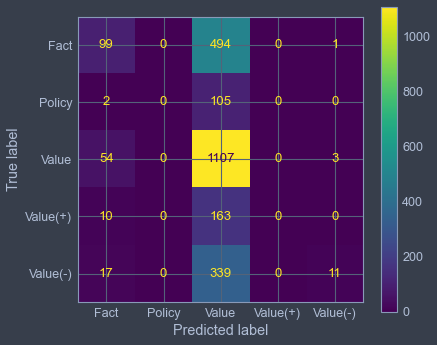

,Precision,Recall,F1
Fact,0.543956,0.166667,0.255155
Policy,0.000000,0.000000,0.000000
Value,0.501359,0.951031,0.656584
Value(+),0.000000,0.000000,0.000000
Value(-),0.733333,0.029973,0.057592


In [45]:
# Linear SVM model -> loss = 'hinge'

sgd_classifier = SGDClassifier(n_jobs=-1, penalty="l2", verbose = 1, shuffle=True, 
                               loss="hinge", max_iter=max_iterations)

sgd_classifier.fit(X_train, y_train)
print_metrics(y_test, sgd_classifier.predict(X_test), sgd_classifier.classes_)

## Linear SVM Classifier
To establish a comparison in terms of performance, we will use the Linear SVM classifier.


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3205
max_resources_: 9616
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 3205
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 3
n_resources: 9615
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LibLinear]Accuracy score:  0.46902286902286905


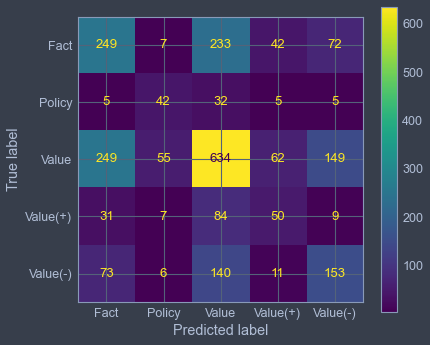

,Precision,Recall,F1
Fact,0.410214,0.412935,0.411570
Policy,0.358974,0.471910,0.407767
Value,0.564559,0.551784,0.558099
Value(+),0.294118,0.276243,0.284900
Value(-),0.394330,0.399478,0.396887


In [26]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import LinearSVC


svm_model = LinearSVC(class_weight="balanced", verbose=1)

svm_gs = HalvingGridSearchCV(svm_model, n_jobs=-1, param_grid = {
    "C": [1,2,5,10],
    "loss": ["hinge", "squared_hinge"]
}, cv=5, scoring="f1_weighted", verbose=3)

svm_gs.fit(X_train, y_train)
print_metrics(y_test, svm_gs.predict(X_test), svm_gs.classes_)

## Logistic Regression Classifier
We can now do the same apply the Logistic Regression classifier and compare it with the previously obtained models with SGD optimization.
